In [45]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor



In [46]:

# ==============================
# 1. Coleta de dados
# ==============================
ouro = yf.Ticker("GC=F")  # Ouro futuro
df = ouro.history(period="20y")
X = df['Close']



In [47]:
# ==============================
# 2. Teste de Estacionariedade (ADF)
# ==============================
print("\n===== Teste ADF (Dickey-Fuller Aumentado) =====")
adf_result = adfuller(X.dropna())
print("Estatística ADF:", adf_result[0])
print("p-valor:", adf_result[1])
print("Valores críticos:", adf_result[4])

if adf_result[1] < 0.05:
    print("Conclusão: Série estacionária (rejeita H0)")
else:
    print("Conclusão: Série não estacionária (não rejeita H0)")




===== Teste ADF (Dickey-Fuller Aumentado) =====
Estatística ADF: 1.959026490698939
p-valor: 0.9986172852509855
Valores críticos: {'1%': np.float64(-3.431659055967043), '5%': np.float64(-2.862118461132801), '10%': np.float64(-2.5670779155711902)}
Conclusão: Série não estacionária (não rejeita H0)


In [48]:
# ==============================
# 3. Ajuste do ARIMA
# ==============================
if adf_result[1] >= 0.05:
    d = 1  # diferenciar para estacionarizar
else:
    d = 0

order = (1, d, 1)
model = sm.tsa.ARIMA(X, order=order)
results = model.fit()

print("\n===== Resumo do ARIMA =====")
print(results.summary())



/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



===== Resumo do ARIMA =====
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5030
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -21237.043
Date:                Sun, 10 Aug 2025   AIC                          42480.086
Time:                        21:04:29   BIC                          42499.655
Sample:                             0   HQIC                         42486.942
                               - 5030                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0329      0.345      0.096      0.924      -0.642       0.708
ma.L1         -0.0551      0.344     -0.160      0.873      -0.730       0.620
sigma2       272.7748  

In [49]:
# ==============================
# 4. Função para testar ordens diferentes
# ==============================
def testa_arima(order):
    model = sm.tsa.ARIMA(X, order=order)
    results = model.fit()
    print(f"\n=== ARIMA{order} ===")
    print("AIC:", results.aic)
    print("BIC:", results.bic)
    print(results.summary())

# Exemplo de testes
testa_arima((1,1,0))
# testa_arima((0,1,1))




=== ARIMA(1, 1, 0) ===
AIC: 42478.094102085466
BIC: 42491.14005495781
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5030
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -21237.047
Date:                Sun, 10 Aug 2025   AIC                          42478.094
Time:                        21:04:30   BIC                          42491.140
Sample:                             0   HQIC                         42482.665
                               - 5030                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0220      0.009     -2.511      0.012      -0.039      -0.005
sigma2       272.6246      2.581    105.621      0.000     2

/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [50]:
# ==============================
# 5. Teste de Ljung-Box nos resíduos
# ==============================
def ljung_box_arima(order):
    model = sm.tsa.ARIMA(X, order=order)
    results = model.fit()
    resid = np.array(results.resid.dropna())
    print(f"\n=== Teste Ljung-Box para ARIMA{order} ===")
    for lag in [1, 5, 10]:
        lb = acorr_ljungbox(resid, lags=[lag], return_df=True)
        print(f"Lag {lag}:\n", lb, "\n")

ljung_box_arima((0,1,1))
ljung_box_arima((1,1,0))



/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== Teste Ljung-Box para ARIMA(0, 1, 1) ===
Lag 1:
     lb_stat  lb_pvalue
1  0.006651      0.935 

Lag 5:
     lb_stat  lb_pvalue
5  5.605908   0.346472 

Lag 10:
      lb_stat  lb_pvalue
10  14.60426    0.14717 


=== Teste Ljung-Box para ARIMA(1, 1, 0) ===
Lag 1:
     lb_stat  lb_pvalue
1  0.006349   0.936493 

Lag 5:
     lb_stat  lb_pvalue
5  5.609084   0.346133 

Lag 10:
       lb_stat  lb_pvalue
10  14.597673   0.147433 



/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


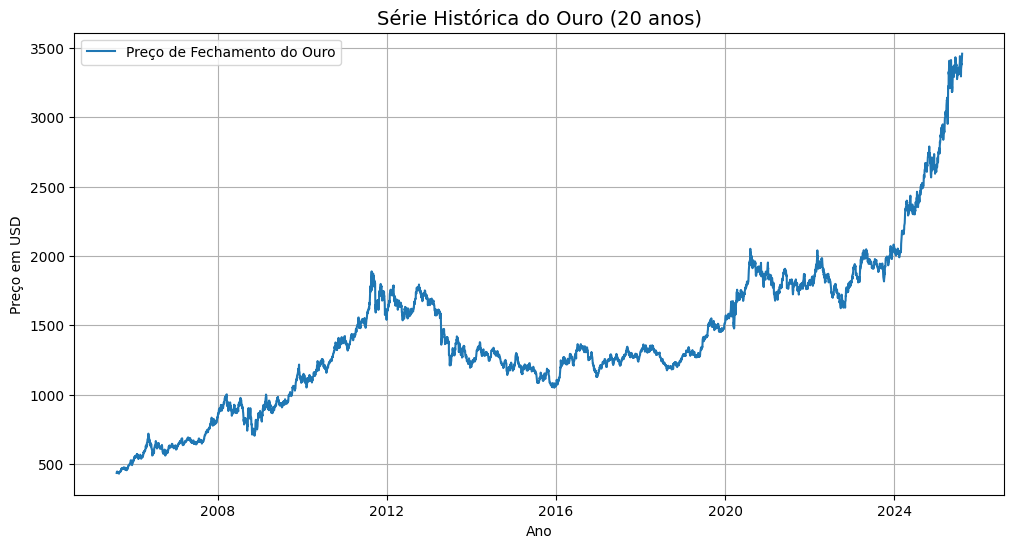

In [51]:
# ==============================
# 6. Visualização
# ==============================
plt.figure(figsize=(12,6))
plt.plot(X, label='Preço de Fechamento do Ouro')
plt.title('Série Histórica do Ouro (20 anos)', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('Preço em USD')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
# --- Função para avaliar modelos ARIMA ---
def avaliar_arima(order, X, split_ratio=0.8):
    """
    Avalia um ARIMA com base em AIC, BIC e erros de previsão (MAE, RMSE, MAPE).
    """
    # Split treino/teste
    split_point = int(len(X) * split_ratio)
    X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
    
    # Ajustar no treino
    model = sm.tsa.ARIMA(X_train, order=order)
    results = model.fit()
    
    # Previsão para o período de teste
    forecast = results.forecast(steps=len(X_test))
    
    # Métricas
    mae = mean_absolute_error(X_test, forecast)
    rmse = np.sqrt(mean_squared_error(X_test, forecast))
    mape = np.mean(np.abs((X_test - forecast) / X_test)) * 100
    
    print(f"\n=== Avaliação ARIMA{order} ===")
    print("AIC:", results.aic)
    print("BIC:", results.bic)
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("MAPE (%):", mape)
    
    return {
        "order": order,
        "AIC": results.aic,
        "BIC": results.bic,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    }

# --- Exemplo de uso ---
avaliar_arima((1,1,1), X)
avaliar_arima((0,1,1), X)
avaliar_arima((1,1,0), X)

/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return ge


=== Avaliação ARIMA(1, 1, 1) ===
AIC: 32870.862695896765
BIC: 32889.762045412615
MAE: 461.8624339241624
RMSE: 667.5822237827396
MAPE (%): nan


/tmp/ipykernel_10477/1542006440.py:20: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((X_test - forecast) / X_test)) * 100
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lslima/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, f


=== Avaliação ARIMA(0, 1, 1) ===
AIC: 32868.863988923695
BIC: 32881.4635552676
MAE: 461.8378555373953
RMSE: 667.5630403344958
MAPE (%): nan

=== Avaliação ARIMA(1, 1, 0) ===
AIC: 32868.86279601385
BIC: 32881.46236235775
MAE: 461.8413925069536
RMSE: 667.5658012143977
MAPE (%): nan


{'order': (1, 1, 0),
 'AIC': np.float64(32868.86279601385),
 'BIC': np.float64(32881.46236235775),
 'MAE': 461.8413925069536,
 'RMSE': np.float64(667.5658012143977),
 'MAPE': nan}